In [1]:
# Data Handeling
import pandas as pd
import numpy as np
import time

# Data Exploration
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt

# Classification Models
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

# Pre processing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector

# Metric Calculations
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

# Optimization
from sklearn.model_selection import GridSearchCV

# Sampling Libraries
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Concept Drift Detection tools
from sklearn.cluster import KMeans
from scipy import stats

# supress warning outputs
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Group 2 Bank Fraud Detection
# Stephen Montgomery (smontg12@depaul.edu)
# John Bolgert (jbolgert@depaul.edu)

In [2]:
df = pd.read_csv('raw.csv')

In [3]:
# review distributions and look for outliers in min & max like negative or large numbers
df.describe()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000
mean,0.011029,0.562696,0.493694,16.718568,86.587867,33.689080,1.025705e+00,8.661499,1572.692049,5665.296605,...,0.889676,10.839303,0.222988,515.851010,0.025242,7.544940,0.576947,1.018312,0.0,3.288674
std,0.104438,0.290343,0.289125,44.046230,88.406599,12.025799,5.381835e+00,20.236155,1005.374565,3009.380665,...,0.313293,12.116875,0.416251,487.559902,0.156859,8.033106,0.494044,0.180761,0.0,2.209994
min,0.000000,0.100000,0.000001,-1.000000,-1.000000,10.000000,4.036860e-09,-15.530555,1.000000,-170.603072,...,0.000000,-1.000000,0.000000,190.000000,0.000000,-1.000000,0.000000,-1.000000,0.0,0.000000
25%,0.000000,0.300000,0.225216,-1.000000,19.000000,20.000000,7.193246e-03,-1.181488,894.000000,3436.365848,...,1.000000,-1.000000,0.000000,200.000000,0.000000,3.103053,0.000000,1.000000,0.0,1.000000
50%,0.000000,0.600000,0.492153,-1.000000,52.000000,30.000000,1.517574e-02,-0.830507,1263.000000,5319.769349,...,1.000000,5.000000,0.000000,200.000000,0.000000,5.114321,1.000000,1.000000,0.0,3.000000
75%,0.000000,0.800000,0.755567,12.000000,130.000000,40.000000,2.633069e-02,4.984176,1944.000000,7680.717827,...,1.000000,25.000000,0.000000,500.000000,0.000000,8.866131,1.000000,1.000000,0.0,5.000000
max,1.000000,0.900000,0.999999,383.000000,428.000000,90.000000,7.845690e+01,112.956928,6700.000000,16715.565404,...,1.000000,32.000000,1.000000,2100.000000,1.000000,85.899143,1.000000,2.000000,0.0,7.000000


# Data Exploration

### Obtain median cost of Fraud

In [4]:
median_fraud = df[(df['fraud_bool']==1)&(df['intended_balcon_amount']>0)]['intended_balcon_amount'].median()
print('The Meidan Fraud Transfer amount is :', median_fraud)

The Meidan Fraud Transfer amount is : 34.70264688784764


### Distribution Explortation

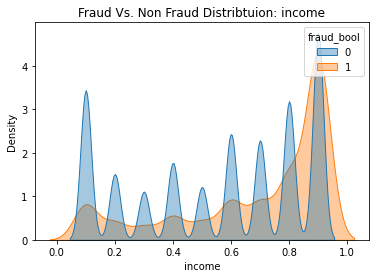

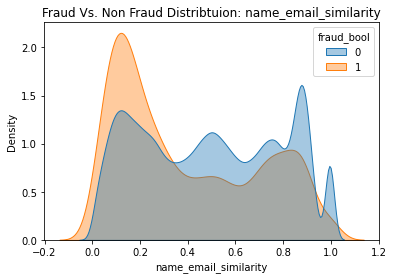

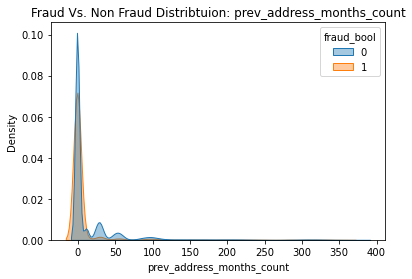

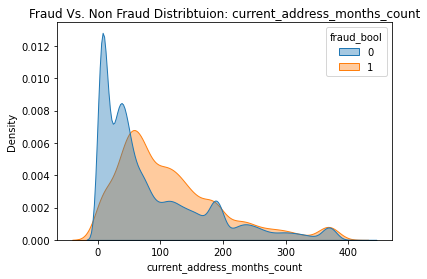

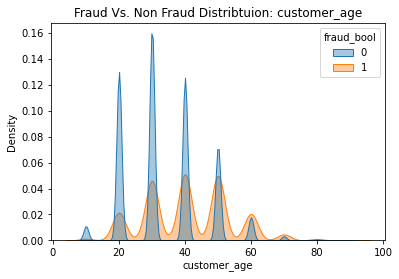

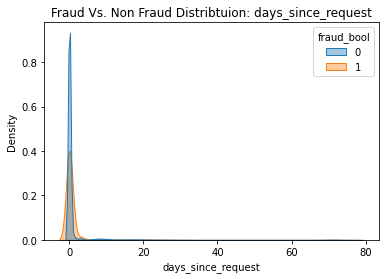

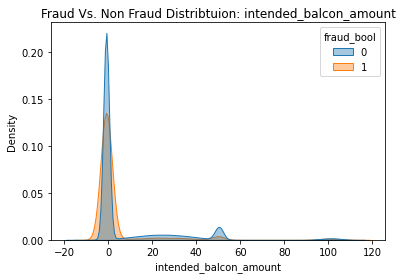

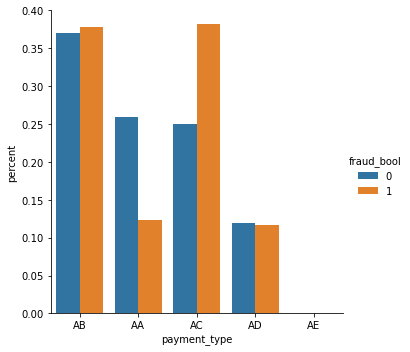

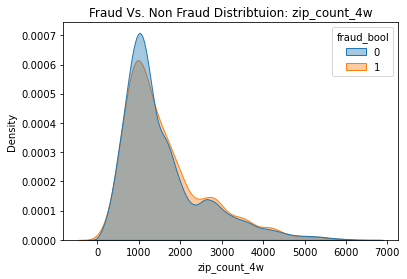

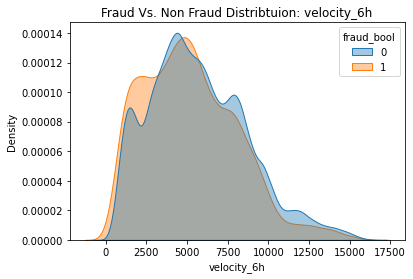

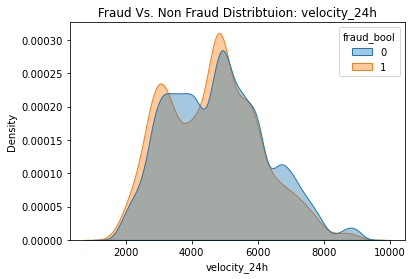

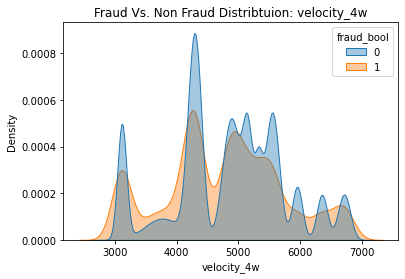

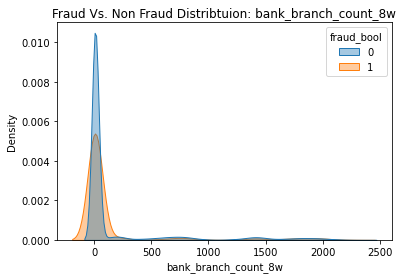

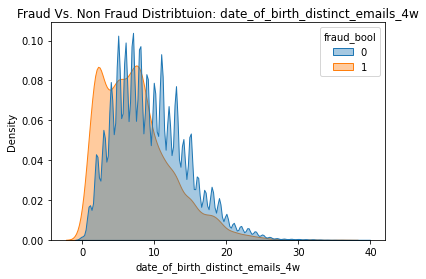

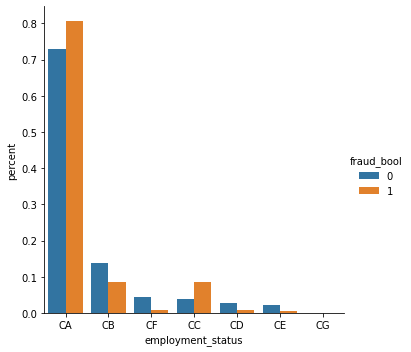

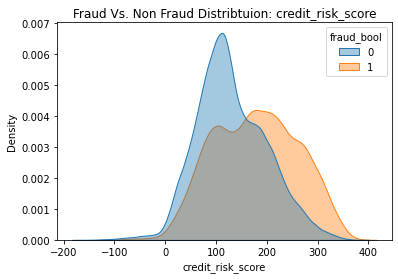

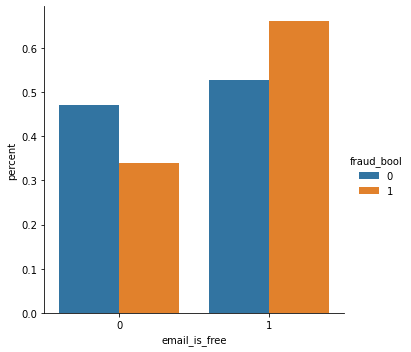

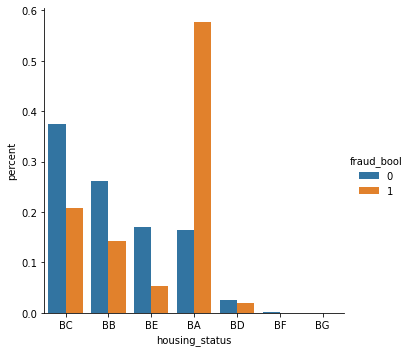

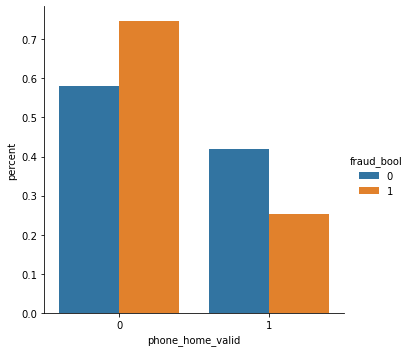

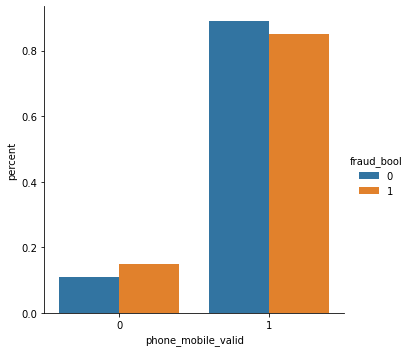

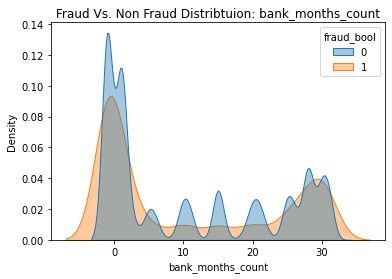

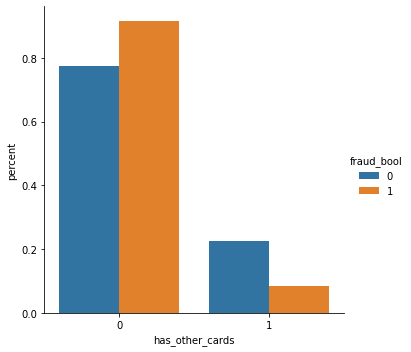

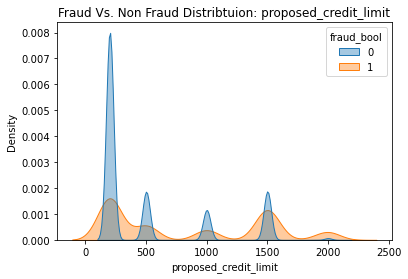

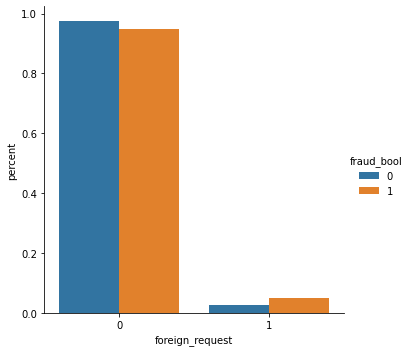

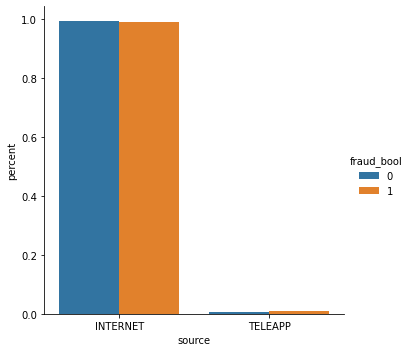

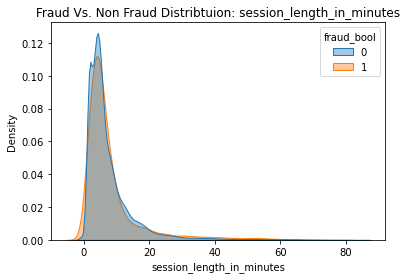

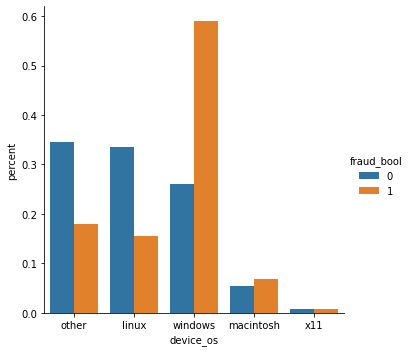

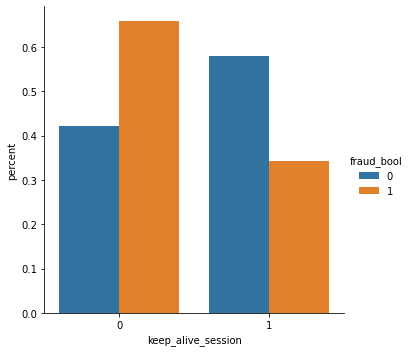

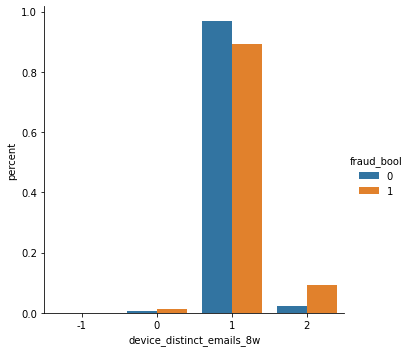

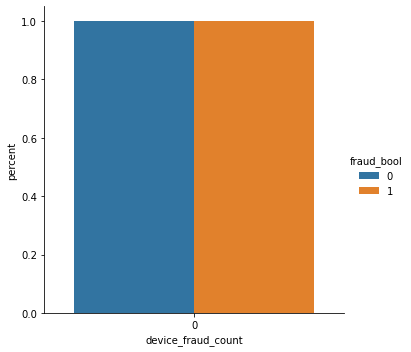

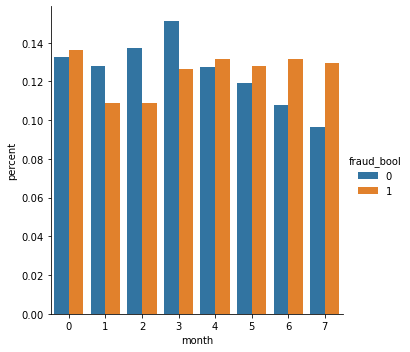

In [5]:
features = list(df.columns)
for col in features:
    if is_numeric_dtype(df[col]):
        if col == 'fraud_bool':
            continue
        if len(df[col].unique())<5 or col=='month':
            col_df = df.groupby('fraud_bool')[col].value_counts(normalize=True).rename('percent').reset_index()
            sns.catplot(data=col_df, y='percent',x=col,hue='fraud_bool',orient='v',kind='bar')
            plt.show()
        else:
            title = 'Fraud Vs. Non Fraud Distribtuion: '+col
            sns.kdeplot(data=df, x=col, hue="fraud_bool", fill=True, common_norm=False, alpha=0.4).set(title=title)
            plt.show()
    else:
        col_df = df.groupby('fraud_bool')[col].value_counts(normalize=True).rename('percent').reset_index()
        sns.catplot(data=col_df, y='percent',x=col,hue='fraud_bool',orient='v',kind='bar')
        plt.show()

### Correlation Exploration

# Pre Processing 

In [6]:
df_use = df[df['month']==7]
df_use.drop('month',axis=1,inplace=True)

### Null Values

In [7]:
# below code looks for the frequency of null or negative values per feature for overall data and the fraud data
features = list(df_use.columns)
total_rows = len(df_use)
total_fraud = len(df_use[df_use['fraud_bool']==1])
for col in features:
    if is_numeric_dtype(df_use[col]):
        if col == 'fraud_bool':
            continue
        if len(df_use[col].unique())<5 or col=='month':
            if len(df_use[df_use[col]<0])>0:
                total_null = len(df_use[df_use[col]<0])
                fraud_null = len(df_use[(df_use[col]<0) & (df_use['fraud_bool']==1)])
                print('NULLS for Categorical Var {}'.format(col))
                print('NULLs: {} records {}% of total'.format(total_null,round(total_null/total_rows,2)*100))
                print('Fraud Nulls: {} records {}% of total fraud'.format(fraud_null,round(fraud_null/total_fraud,2)*100))
                print(' ')
        else:
            if len(df_use[df_use[col]<0])>0:
                total_null = len(df_use[df_use[col]<0])
                fraud_null = len(df_use[(df_use[col]<0) & (df_use['fraud_bool']==1)])
                print('NULLS for Numeric Var {}'.format(col))
                print('NULLs: {} records {}% of total'.format(total_null,round(total_null/total_rows,2)*100))
                print('Fraud Nulls: {} records {}% of total fraud'.format(fraud_null,round(fraud_null/total_fraud,2)*100))
                print(' ')

NULLS for Numeric Var prev_address_months_count
NULLs: 63204 records 65.0% of total
Fraud Nulls: 1252 records 88.0% of total fraud
 
NULLS for Numeric Var current_address_months_count
NULLs: 835 records 1.0% of total
Fraud Nulls: 4 records 0.0% of total fraud
 
NULLS for Numeric Var intended_balcon_amount
NULLs: 78967 records 82.0% of total
Fraud Nulls: 1310 records 92.0% of total fraud
 
NULLS for Numeric Var velocity_6h
NULLs: 10 records 0.0% of total
Fraud Nulls: 0 records 0.0% of total fraud
 
NULLS for Numeric Var credit_risk_score
NULLs: 353 records 0.0% of total
Fraud Nulls: 0 records 0.0% of total fraud
 
NULLS for Numeric Var bank_months_count
NULLs: 27635 records 28.999999999999996% of total
Fraud Nulls: 518 records 36.0% of total fraud
 
NULLS for Numeric Var session_length_in_minutes
NULLs: 199 records 0.0% of total
Fraud Nulls: 1 records 0.0% of total fraud
 
NULLS for Categorical Var device_distinct_emails_8w
NULLs: 14 records 0.0% of total
Fraud Nulls: 0 records 0.0% of 

### Addressing null values

In [8]:
### Discretize each feature that has greater than 10% missing values for fraud 
features = list(df_use.columns)
total_rows = len(df_use)
total_fraud = len(df_use[df_use['fraud_bool']==1])

# loop through and turn the numeric features into categorical features by using pandas binning
for col in features:
    if is_numeric_dtype(df_use[col]):
        if col == 'fraud_bool' :
            continue
        if len(df_use[col].unique())<5 or col=='month':
            if len(df_use[df_use[col]<0])>0:
                print(col, ' convert numeric to categorical feature')
                total_null = len(df_use[df_use[col]<0])
                fraud_null = len(df_use[(df_use[col]<0) & (df_use['fraud_bool']==1)])
                df[col]=df[col].astype(str)
        else:
            if len(df_use[df_use[col]<0])>0:
                total_null = len(df_use[df_use[col]<0])
                fraud_null = len(df_use[(df_use[col]<0) & (df_use['fraud_bool']==1)])
                if fraud_null/total_fraud > .1:
                    print(col, ' discretize feature into 5 bins')
                    # Discretize the feature
                    min_val = df_use[col].min()
                    max_val = df_use[col].max()
                    bins = [min_val-1]
                    bin_labels = ['Missing']
                    for i in range(5):
                        bins.append(i*max_val/4)
                        bin_labels.append('bin_{}'.format(i))
                    bin_labels.pop()
                    df_use[col] = pd.cut(df_use[col], bins=bins, labels=bin_labels)
                else:
                    print(col, ' fill using median')
                    # Fill negative values with median vallue
                    med= df[col].median()
                    df_use.loc[df_use[col]<0,col]=med

df_use.describe()

prev_address_months_count  discretize feature into 5 bins
current_address_months_count  fill using median
intended_balcon_amount  discretize feature into 5 bins
velocity_6h  fill using median
credit_risk_score  fill using median
bank_months_count  discretize feature into 5 bins
session_length_in_minutes  fill using median
device_distinct_emails_8w  convert numeric to categorical feature


,fraud_bool,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,...,email_is_free,phone_home_valid,phone_mobile_valid,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count
count,96843.000000,96843.000000,96843.000000,96843.000000,96843.000000,9.684300e+04,96843.000000,96843.000000,96843.000000,96843.000000,...,96843.000000,96843.000000,96843.000000,96843.000000,96843.000000,96843.000000,96843.000000,96843.000000,96843.000000,96843.0
mean,0.014746,0.617458,0.484813,71.022366,33.074461,8.843276e-01,985.613013,3605.877015,3260.626953,3343.593679,...,0.497238,0.483628,0.900013,0.193488,465.658230,0.021612,6.597648,0.648173,1.008436,0.0
std,0.120533,0.279313,0.274916,78.210880,11.161279,5.336778e+00,651.388554,1977.865252,1157.178232,623.973248,...,0.499995,0.499734,0.299984,0.395035,440.656589,0.145415,7.539315,0.477543,0.123209,0.0
min,0.000000,0.100000,0.000038,0.000000,10.000000,1.414624e-07,1.000000,1.291427,1300.307314,2922.993890,...,0.000000,0.000000,0.000000,0.000000,190.000000,0.000000,0.000872,0.000000,-1.000000,0.0
25%,0.000000,0.400000,0.252219,12.000000,30.000000,6.866274e-03,569.000000,2269.872990,2524.007433,3088.880905,...,0.000000,0.000000,1.000000,0.000000,200.000000,0.000000,2.275631,0.000000,1.000000,0.0
50%,0.000000,0.700000,0.487240,40.000000,30.000000,1.435603e-02,844.000000,3462.423342,3026.777525,3122.498634,...,0.000000,0.000000,1.000000,0.000000,200.000000,0.000000,4.302200,1.000000,1.000000,0.0
75%,0.000000,0.900000,0.708949,110.000000,40.000000,2.446317e-02,1200.000000,4544.834026,3600.931898,3165.170450,...,1.000000,1.000000,1.000000,0.000000,500.000000,0.000000,7.960074,1.000000,1.000000,0.0
max,1.000000,0.900000,0.999996,399.000000,90.000000,7.845690e+01,6451.000000,16356.364000,9199.470549,6917.483622,...,1.000000,1.000000,1.000000,1.000000,2000.000000,1.000000,83.376775,1.000000,2.000000,0.0


In [9]:
# Splitting into dependent vs. independent features
y_use = df_use['fraud_bool']
x_use = df_use.drop('fraud_bool',axis=1)
#X = df['fraud_bool']
#y = df.drop('fraud_bool',axis=1)
#x_use,  x_remove, y_use , y_remove = train_test_split(X, y, test_size=0.95, random_state=42)

### Categorical Conversion

In [10]:
# Convert Categorical
df_dummies = pd.get_dummies(x_use)

### Data Normalization

In [11]:
# Normalize all the columns to range between 0 and 1
x = df_dummies.values
cols = df_dummies.columns
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
x_use_scaled = pd.DataFrame(x_scaled, columns = cols)

### Train Test Split portion of overall data

In [12]:
x_train,  x_test, y_train , y_test = train_test_split(x_use_scaled, y_use, test_size=0.33, random_state=42)

### Feature Importance

In [13]:
# Rank Feature importance based on their mean decrease in impurity using random forest claissifer
clf = RandomForestClassifier(random_state=0)
features = x_train.columns
clf.fit(x_train, y_train)
importances = clf.feature_importances_
len(importances)

63

<AxesSubplot:>

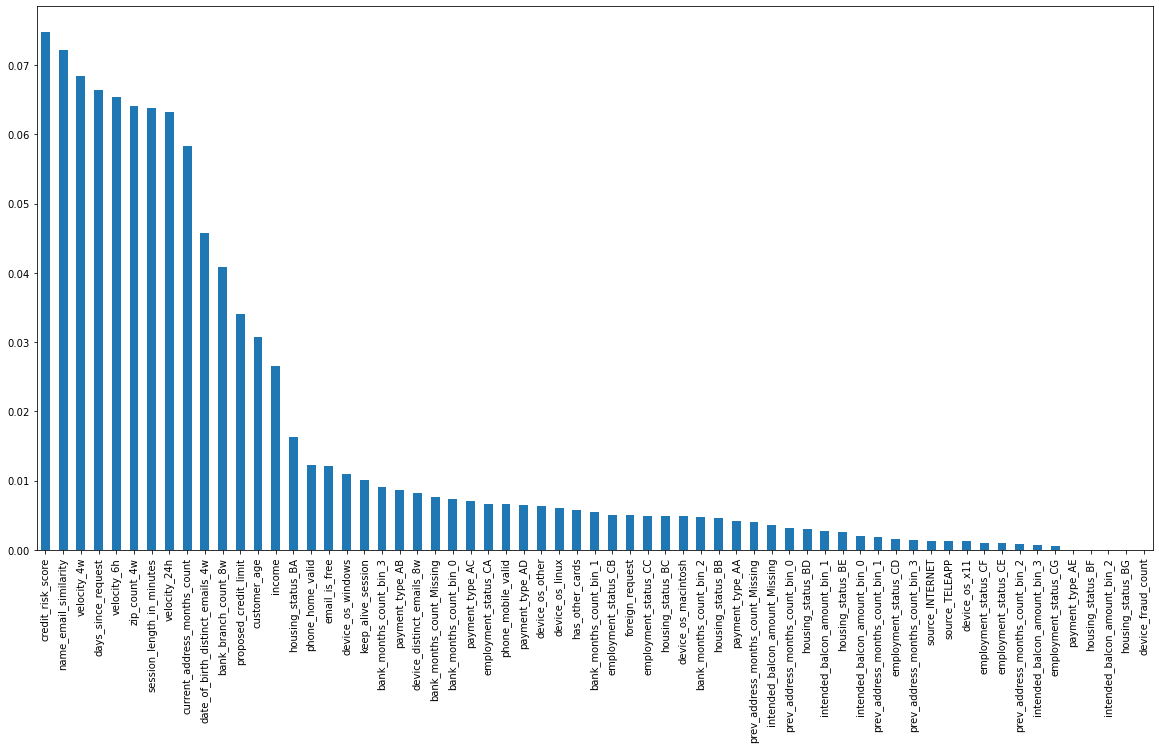

In [14]:
feat_importances = pd.Series(importances, index=features)
feat_importances = feat_importances.sort_values(ascending=False)
feat_importances.plot.bar(figsize=(20, 10))

# Model Metric & Training Custom Functions

### Model Optimization & Training Function

In [15]:
# function that fits the data then returns the probabilites of fraud for the dataset
def train_predict(x_train, y_train, x_test, y_test, model):
    model.fit(x_train, y_train)
    probabilities = model.predict_proba(x_test)
    
    return(probabilities)

### Cost Savings Optimization Function 

In [16]:
### Define Preformance Metrics Function

# below function will find the optimal probability to predict fraud based on the input costs assoicated with False negatie
# and Cost of False postive
def optimize_cost(Cost_FN, Cost_FP,probabilities, y_test):
    #Intalize the varibels to store optimal metrics
    opt_savings = 'NULL'
    opt_prob = 'NULL'
    opt_f1 = ['NULL','NULL']
    
    # loop through each probability percent threshold measure cost savings then store probability and savings if it is better
    # than current optimal savings
    for prob in np.arange(.01,1,.01):
        predictions = probabilities[:,1].copy()
        predictions[predictions>=prob] = 1
        predictions[predictions<prob] = 0
        cm = confusion_matrix(y_test, predictions)
        savings = cm[1,1]*Cost_FN - cm[0,1]*Cost_FP
        f1_score_iter = f1_score(y_test, predictions)
        if opt_savings=='NULL':
            opt_savings = savings
            opt_prob = prob
        elif savings > opt_savings:
            opt_savings = savings
            opt_prob = prob
        if opt_f1[0]=='NULL':
            opt_f1[0] = f1_score_iter
            opt_f1[1] = prob
        elif f1_score_iter > opt_f1[0]:
            opt_f1[0] = f1_score_iter
            opt_f1[1] = prob
    
    # calculate metrics for the optimal probability then return them
    predictions = probabilities[:,1]
    predictions[predictions>=opt_prob] = 1
    predictions[predictions<opt_prob] = 0 
    f1 = f1_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, probabilities[:, 1])
    return ([opt_prob, opt_savings,f1 ,precision,recall,roc_auc,opt_f1] )

### Sampeling & Ratio Testing Function

In [17]:
# function test each combination of the choosen grid search parameters along with Sampeling technqiue and feature amount
def test_create_sampled_data(class_probabilites, x_train, y_train, x_test, y_test, opt_model, Cost_FN, Cost_FP):
    # Sampeling techniques to test
    columns = ['ROS','RUS','SMOTE']
    indexes = class_probabilites
    # define metric dataframes
    cost_metrics_df = pd.DataFrame(columns=columns ,index=indexes )
    f1_metrics_df = pd.DataFrame(columns=columns ,index=indexes )
    Recall_metrics_df = pd.DataFrame(columns=columns ,index=indexes )
    # loop through sampeling ratios to test for each sampeling technique for a given feature amount
    for ratio in class_probabilites:
        print('  testing ratio amount: ', ratio)
        
        # Random Over Sampeling
        oversample = RandomOverSampler(sampling_strategy=ratio)
        x_sampled, y_sampled = oversample.fit_resample(x_train,y_train)
        print('    Finished Oversampling')
        test_probas = train_predict(x_sampled, y_sampled, x_test, y_test, opt_model)
        print('    Finished Oversampling model training')
        over_metrics = optimize_cost(Cost_FN, Cost_FP,test_probas, y_test)
        print('    Finished Oversampling model cost optimization')
        # store resuts in metrics dataframe
        cost_metrics_df.loc[ratio,'ROS'] =over_metrics[1]
        f1_metrics_df.loc[ratio,'ROS'] =over_metrics[6][0]
        Recall_metrics_df.loc[ratio,'ROS'] =over_metrics[4]
        
        # Random Under Sampeling
        undersample = RandomUnderSampler(sampling_strategy=ratio)
        x_sampled, y_sampled = undersample.fit_resample(x_train,y_train)
        print('    Finished Undersampling')
        test_probas = train_predict(x_sampled, y_sampled, x_test, y_test, opt_model)
        print('    Finished Undersampling model training')
        over_metrics = optimize_cost(Cost_FN, Cost_FP,test_probas, y_test)
        print('    Finished Undersampling model cost optimization')
        # store resuts in metrics dataframe
        cost_metrics_df.loc[ratio,'RUS'] =over_metrics[1]
        f1_metrics_df.loc[ratio,'RUS'] =over_metrics[6][0]
        Recall_metrics_df.loc[ratio,'RUS'] =over_metrics[4]
        
        # SMOTE Sampeling
        synth_oversample = SMOTE(sampling_strategy=ratio)
        x_sampled, y_sampled = synth_oversample.fit_resample(x_train,y_train)
        print('    Finished Sythetic Oversampling Technique')
        test_probas = train_predict(x_sampled, y_sampled, x_test, y_test, opt_model)
        print('    Finished Sythetic Oversampling Technique model training')
        over_metrics = optimize_cost(Cost_FN, Cost_FP,test_probas, y_test)
        print('    Finished Sythetic Oversampling model cost optimization')
        # store resuts in metrics dataframe
        cost_metrics_df.loc[ratio,'SMOTE'] =over_metrics[1]
        f1_metrics_df.loc[ratio,'SMOTE'] =over_metrics[6][0]
        Recall_metrics_df.loc[ratio,'SMOTE'] =over_metrics[4]
    
    # reterive the optimal/best metrics from each of the overal dataframes and the assoicated ratio/technique parameters
    max_ratio_cost = cost_metrics_df.max(axis=1).sort_values(ascending=False).index[0]
    max_method_cost = cost_metrics_df.max().sort_values(ascending=False).index[0]
    max_savings = list(cost_metrics_df.max().sort_values(ascending=False))[0]
    
    max_ratio_f1 = f1_metrics_df.max(axis=1).sort_values(ascending=False).index[0]
    max_method_f1 = f1_metrics_df.max().sort_values(ascending=False).index[0]
    max_f1 = list(f1_metrics_df.max().sort_values(ascending=False))[0]
    
    max_ratio_recall = Recall_metrics_df.max(axis=1).sort_values(ascending=False).index[0]
    max_method_recall = Recall_metrics_df.max().sort_values(ascending=False).index[0]
    max_recall = list(Recall_metrics_df.max().sort_values(ascending=False))[0]
    
    # return the optimal parameters/techiques 
    return ([max_savings, max_method_cost, max_ratio_cost],
            [max_f1, max_method_f1,max_ratio_f1],
            [max_recall, max_method_recall, max_ratio_recall])

### Plot results Function

In [18]:
# function that plots each optimal combination per feature amount along with the best metric achieved
def view_optimization(Results_df,Opt_data_frame, model_name):
    plt.figure(figsize=(15, 6))
    for metric in Results_df.columns:
        pref_dic = {}
        for f_amount in Results_df.index:
            method = Results_df.loc[f_amount,metric]
            label = 'F amt{}&{}'.format(f_amount,method)
            value = Opt_data_frame.loc[f_amount,metric]
            pref_dic[label]=value
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(x=list(pref_dic.keys()), y=list(pref_dic.values())).set(title='{}: Optimal {} per Feature Amount'.format(model_name,metric))
        ax.set_xticklabels(list(pref_dic.keys()), rotation=50, ha='right')
        #fig.set_xticklabels(list(pref_dic.keys()), rotation=50, ha='right')

# Model Building & Optimization on Base Data

In this section we build optimize serveral models on the base data using a combination of the following parameters
1. Feature amount 
2. Sampeling Ratios
3. Sampeling Method
4. Model specific search grid

In [19]:
# Define Optimization metrics and grid search space

# feature amounts to test
Feature_Amounts = [5, 10, 15, 25, 40, len(x_train.columns)]
# Class probabilities to test
class_probabilites = [.25,.5,.75]

# Choosen cost assoicated with FP and FN for custom loss function that optimizes the savings using predicted fraud probability
cost_fp = 10
cost_fn = median_fraud
metrics = ['Cost_Savings','F1_Score','Recall']
models = ['RandomForestClassifier','KNNClassifier','MLPClassifier','Suport Vector Machine','SGDClassifier',
         'GradientBoostingClassifier','AdaBoostClassifier','GaussianProcessClassifier']
model_comparisons_df = pd.DataFrame(columns=metrics ,index=models)

### Model building: RandomForestClassifier

In [20]:
# Find Optimal Feature Sampeling & ratio Amount
print('starting RandomForest Optimization')
start_time = time.time()
# Create DataFrane to store metrics and Feature_amt, Ratio, and Method Combinations in 
columns = ['Cost_Savings','F1_Score','Recall']
indexes = Feature_Amounts
Opt_data_frame = pd.DataFrame(columns=columns ,index=indexes)
method_ratio_combo =  pd.DataFrame(columns=columns ,index=indexes)
for f_amount in Feature_Amounts:
    print('testing Feature amount: ', f_amount)
    x_train_data = x_train[feat_importances[:f_amount].index]
    x_test_data = x_test[feat_importances[:f_amount].index]
    
    # optimize parameters 
    rfc = RandomForestClassifier()
    parameters = {
        'n_estimators' : [25,50,75],
        'max_depth':[2,4,5]
    }
    opt_rfc = GridSearchCV(rfc, parameters)
    cost, f1, recall = test_create_sampled_data(class_probabilites, x_train_data, y_train, x_test_data, y_test, opt_rfc, cost_fn, cost_fp)
    
    print('Optimization for {} features completed'.format(f_amount))
    print(' ')
    print('cost optimization results: ',cost)
    print('f1 optimization results: ',f1)
    print('recall optimization results: ',recall)
    
    Opt_data_frame.loc[f_amount,'Cost_Savings'] = cost[0]
    method_ratio_combo.loc[f_amount,'Cost_Savings'] = str(cost[1])+'_'+str(cost[2])
    Opt_data_frame.loc[f_amount,'F1_Score'] = f1[0]
    method_ratio_combo.loc[f_amount,'F1_Score'] = str(f1[1])+'_'+str(f1[2])
    Opt_data_frame.loc[f_amount,'Recall'] = recall[0]
    method_ratio_combo.loc[f_amount,'Recall'] = str(recall[1])+'_'+str(recall[2])

# Get the best strategy combination and metric for each preformance metric
best_savings = Opt_data_frame['Cost_Savings'].max()
opt_feature_amt_savings = Opt_data_frame['Cost_Savings'].sort_values(ascending=False).index[0]
opt_sampel_savings = method_ratio_combo.loc[opt_feature_amt_savings,'Cost_Savings']

best_f1 = Opt_data_frame['F1_Score'].max()
opt_feature_amt_f1 = Opt_data_frame['F1_Score'].sort_values(ascending=False).index[0]
opt_sampel_f1 = method_ratio_combo.loc[opt_feature_amt_f1,'F1_Score']

best_recall = Opt_data_frame['Recall'].max()
opt_feature_amt_recall = Opt_data_frame['Recall'].sort_values(ascending=False).index[0]
opt_sampel_recall = method_ratio_combo.loc[opt_feature_amt_recall,'Recall']

print("Seconds Taken to Optimize RandomForest: ", (time.time() - start_time))

starting RandomForest Optimization
testing Feature amount:  5
  testing ratio amount:  0.25
    Finished Oversampling
    Finished Oversampling model training
    Finished Oversampling model cost optimization
    Finished Undersampling
    Finished Undersampling model training
    Finished Undersampling model cost optimization
    Finished Sythetic Oversampling Technique
    Finished Sythetic Oversampling Technique model training
    Finished Sythetic Oversampling model cost optimization
  testing ratio amount:  0.5
    Finished Oversampling
    Finished Oversampling model training


C:\Users\montg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Finished Oversampling model cost optimization
    Finished Undersampling
    Finished Undersampling model training
    Finished Undersampling model cost optimization
    Finished Sythetic Oversampling Technique
    Finished Sythetic Oversampling Technique model training


C:\Users\montg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Finished Sythetic Oversampling model cost optimization
  testing ratio amount:  0.75
    Finished Oversampling
    Finished Oversampling model training
    Finished Oversampling model cost optimization
    Finished Undersampling
    Finished Undersampling model training


C:\Users\montg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Finished Undersampling model cost optimization
    Finished Sythetic Oversampling Technique
    Finished Sythetic Oversampling Technique model training
    Finished Sythetic Oversampling model cost optimization
Optimization for 5 features completed
 
cost optimization results:  [34.70264688784764, 'RUS', 0.5]
f1 optimization results:  [0.12447636146020347, 'RUS', 0.75]
recall optimization results:  [0.004032258064516129, 'RUS', 0.25]
testing Feature amount:  10
  testing ratio amount:  0.25
    Finished Oversampling
    Finished Oversampling model training
    Finished Oversampling model cost optimization
    Finished Undersampling
    Finished Undersampling model training
    Finished Undersampling model cost optimization
    Finished Sythetic Oversampling Technique
    Finished Sythetic Oversampling Technique model training
    Finished Sythetic Oversampling model cost optimization
  testing ratio amount:  0.5
    Finished Oversampling
    Finished Oversampling model training
   

C:\Users\montg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Finished Sythetic Oversampling model cost optimization
Optimization for 10 features completed
 
cost optimization results:  [98.21588132708587, 'RUS', 0.25]
f1 optimization results:  [0.14859094790777114, 'RUS', 0.25]
recall optimization results:  [0.012096774193548387, 'RUS', 0.25]
testing Feature amount:  15
  testing ratio amount:  0.25
    Finished Oversampling
    Finished Oversampling model training
    Finished Oversampling model cost optimization
    Finished Undersampling
    Finished Undersampling model training
    Finished Undersampling model cost optimization
    Finished Sythetic Oversampling Technique
    Finished Sythetic Oversampling Technique model training
    Finished Sythetic Oversampling model cost optimization
  testing ratio amount:  0.5
    Finished Oversampling
    Finished Oversampling model training
    Finished Oversampling model cost optimization
    Finished Undersampling
    Finished Undersampling model training
    Finished Undersampling model cost 

### Preformance Measurments: RandomForestClassifier

<Figure size 1080x432 with 0 Axes>

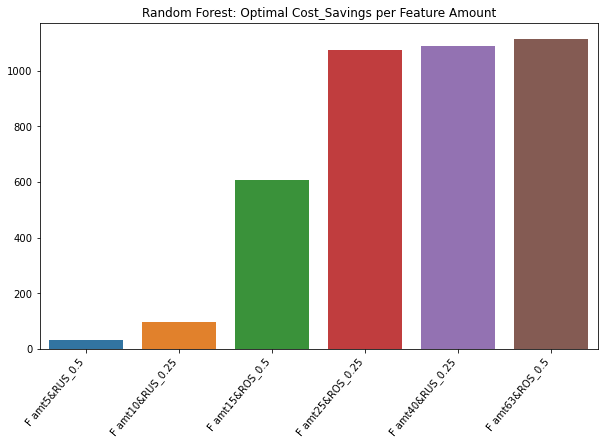

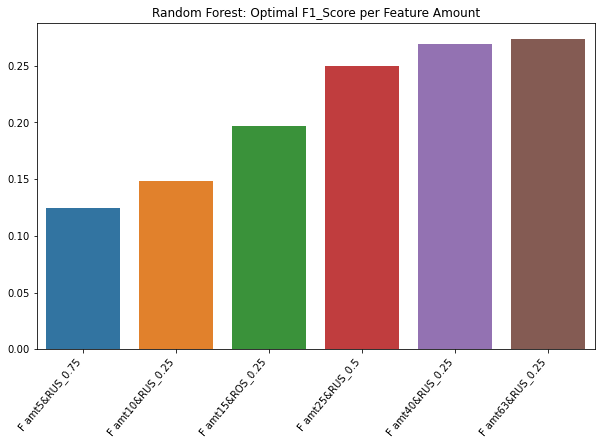

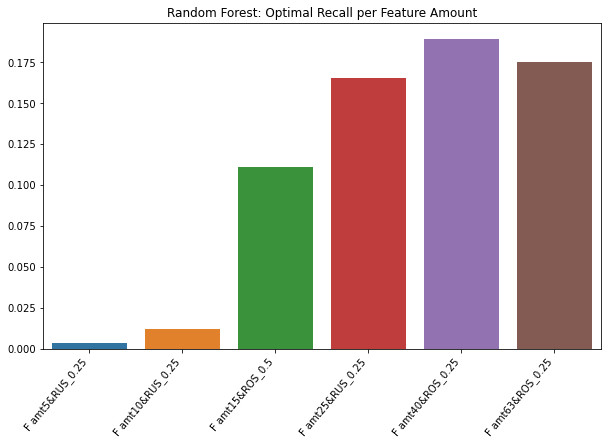

In [21]:
view_optimization(method_ratio_combo,Opt_data_frame,'Random Forest')

### Model building: KNNClassifier

In [22]:
# Find Optimal Feature Sampeling & ratio Amount
print('starting KNN Optimization')
start_time = time.time()
# Create DataFrane to store metrics and Feature_amt, Ratio, and Method Combinations in 
columns = ['Cost_Savings','F1_Score','Recall']
indexes = Feature_Amounts
Opt_data_frame = pd.DataFrame(columns=columns ,index=indexes)
method_ratio_combo =  pd.DataFrame(columns=columns ,index=indexes)
for f_amount in Feature_Amounts:
    print('testing Feature amount: ', f_amount)
    x_train_data = x_train[feat_importances[:f_amount].index]
    x_test_data = x_test[feat_importances[:f_amount].index]
    
    # optimize parameters 
    KNN = KNeighborsClassifier()
    parameters = {
        'n_neighbors' : [3,5,10],
        'weights':['uniform','distance']
    }
    opt_KNN = GridSearchCV(KNN, parameters)
    cost, f1, recall = test_create_sampled_data(class_probabilites, x_train_data, y_train, x_test_data, y_test, opt_KNN, cost_fn, cost_fp)
    
    print('Optimization for {} features completed'.format(f_amount))
    print(' ')
    print('cost optimization results: ',cost)
    print('f1 optimization results: ',f1)
    print('recall optimization results: ',recall)
    
    Opt_data_frame.loc[f_amount,'Cost_Savings'] = cost[0]
    method_ratio_combo.loc[f_amount,'Cost_Savings'] = str(cost[1])+'_'+str(cost[2])
    Opt_data_frame.loc[f_amount,'F1_Score'] = f1[0]
    method_ratio_combo.loc[f_amount,'F1_Score'] = str(f1[1])+'_'+str(f1[2])
    Opt_data_frame.loc[f_amount,'Recall'] = recall[0]
    method_ratio_combo.loc[f_amount,'Recall'] = str(recall[1])+'_'+str(recall[2])

# Get the best strategy combination and metric for each preformance metric
best_savings = Opt_data_frame['Cost_Savings'].max()
opt_feature_amt_savings = Opt_data_frame['Cost_Savings'].sort_values(ascending=False).index[0]
opt_sampel_savings = method_ratio_combo.loc[opt_feature_amt_savings,'Cost_Savings']

best_f1 = Opt_data_frame['F1_Score'].max()
opt_feature_amt_f1 = Opt_data_frame['F1_Score'].sort_values(ascending=False).index[0]
opt_sampel_f1 = method_ratio_combo.loc[opt_feature_amt_f1,'F1_Score']

best_recall = Opt_data_frame['Recall'].max()
opt_feature_amt_recall = Opt_data_frame['Recall'].sort_values(ascending=False).index[0]
opt_sampel_recall = method_ratio_combo.loc[opt_feature_amt_recall,'Recall']

print("Seconds Taken to KNN optimization: ", (time.time() - start_time))

starting KNN Optimization
testing Feature amount:  5
  testing ratio amount:  0.25
    Finished Oversampling
    Finished Oversampling model training
    Finished Oversampling model cost optimization
    Finished Undersampling
    Finished Undersampling model training
    Finished Undersampling model cost optimization
    Finished Sythetic Oversampling Technique
    Finished Sythetic Oversampling Technique model training
    Finished Sythetic Oversampling model cost optimization
  testing ratio amount:  0.5
    Finished Oversampling
    Finished Oversampling model training
    Finished Oversampling model cost optimization
    Finished Undersampling
    Finished Undersampling model training
    Finished Undersampling model cost optimization
    Finished Sythetic Oversampling Technique
    Finished Sythetic Oversampling Technique model training
    Finished Sythetic Oversampling model cost optimization
  testing ratio amount:  0.75
    Finished Oversampling
    Finished Oversampling mode

    Finished Oversampling model training
    Finished Oversampling model cost optimization
    Finished Undersampling
    Finished Undersampling model training
    Finished Undersampling model cost optimization
    Finished Sythetic Oversampling Technique
    Finished Sythetic Oversampling Technique model training
    Finished Sythetic Oversampling model cost optimization
  testing ratio amount:  0.75
    Finished Oversampling
    Finished Oversampling model training
    Finished Oversampling model cost optimization
    Finished Undersampling
    Finished Undersampling model training
    Finished Undersampling model cost optimization
    Finished Sythetic Oversampling Technique
    Finished Sythetic Oversampling Technique model training
    Finished Sythetic Oversampling model cost optimization
Optimization for 63 features completed
 
cost optimization results:  [141.61910995314383, 'RUS', 0.25]
f1 optimization results:  [0.21397756686798966, 'RUS', 0.5]
recall optimization results:  [

<Figure size 1080x432 with 0 Axes>

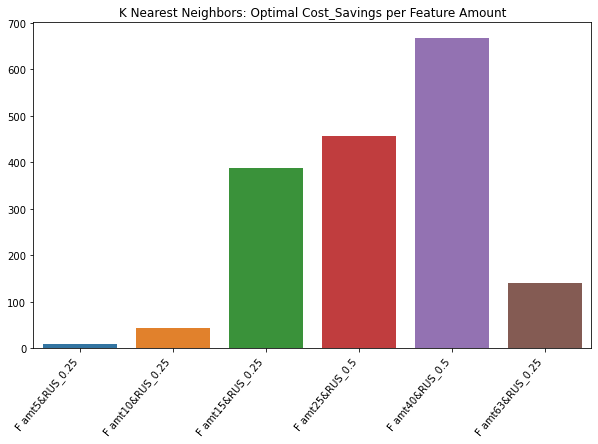

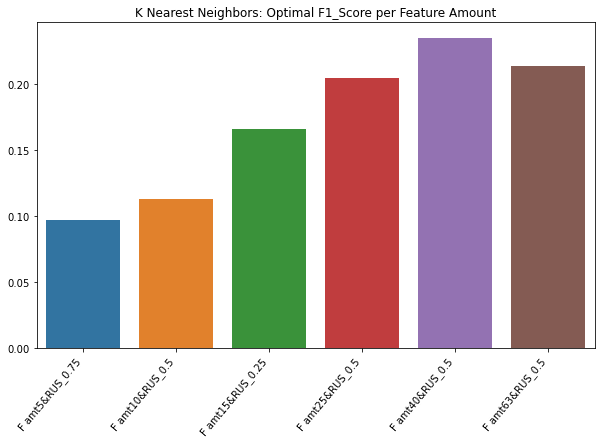

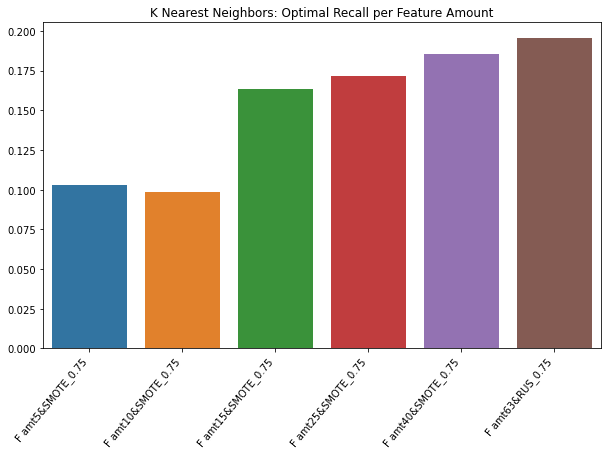

In [23]:
view_optimization(method_ratio_combo,Opt_data_frame,'K Nearest Neighbors')

### Model building: MLPClassifier

In [21]:
# Find Optimal Feature Sampeling & ratio Amount
print('starting MLPClassifier Optimization')
start_time = time.time()
# Create DataFrane to store metrics and Feature_amt, Ratio, and Method Combinations in 
columns = ['Cost_Savings','F1_Score','Recall']
indexes = Feature_Amounts
Opt_data_frame = pd.DataFrame(columns=columns ,index=indexes)
method_ratio_combo =  pd.DataFrame(columns=columns ,index=indexes)
for f_amount in Feature_Amounts:
    print('testing Feature amount: ', f_amount)
    x_train_data = x_train[feat_importances[:f_amount].index]
    x_test_data = x_test[feat_importances[:f_amount].index]
    
    # optimize parameters 
    MLP = MLPClassifier()
    parameters = {
        'hidden_layer_sizes':[(20,10,5,1),(8,4,1),(4,2)],
        'activation':['logistic', 'relu'],
        'solver':['sgd','adam'],
        'learning_rate_init':[.0001,.001],
        'max_iter':[10,20,35]
    }
    opt_MLP = GridSearchCV(MLP, parameters)
    cost, f1, recall = test_create_sampled_data(class_probabilites, x_train_data, y_train, x_test_data, y_test, opt_MLP, cost_fn, cost_fp)
    
    print('Optimization for {} features completed'.format(f_amount))
    print(' ')
    print('cost optimization results: ',cost)
    print('f1 optimization results: ',f1)
    print('recall optimization results: ',recall)
    
    Opt_data_frame.loc[f_amount,'Cost_Savings'] = cost[0]
    method_ratio_combo.loc[f_amount,'Cost_Savings'] = str(cost[1])+'_'+str(cost[2])
    Opt_data_frame.loc[f_amount,'F1_Score'] = f1[0]
    method_ratio_combo.loc[f_amount,'F1_Score'] = str(f1[1])+'_'+str(f1[2])
    Opt_data_frame.loc[f_amount,'Recall'] = recall[0]
    method_ratio_combo.loc[f_amount,'Recall'] = str(recall[1])+'_'+str(recall[2])

# Get the best strategy combination and metric for each preformance metric
best_savings = Opt_data_frame['Cost_Savings'].max()
opt_feature_amt_savings = Opt_data_frame['Cost_Savings'].sort_values(ascending=False).index[0]
opt_sampel_savings = method_ratio_combo.loc[opt_feature_amt_savings,'Cost_Savings']

best_f1 = Opt_data_frame['F1_Score'].max()
opt_feature_amt_f1 = Opt_data_frame['F1_Score'].sort_values(ascending=False).index[0]
opt_sampel_f1 = method_ratio_combo.loc[opt_feature_amt_f1,'F1_Score']

best_recall = Opt_data_frame['Recall'].max()
opt_feature_amt_recall = Opt_data_frame['Recall'].sort_values(ascending=False).index[0]
opt_sampel_recall = method_ratio_combo.loc[opt_feature_amt_recall,'Recall']

print("Seconds Taken to MLPClassifier: ", (time.time() - start_time))

starting MLPClassifier Optimization
testing Feature amount:  5
  testing ratio amount:  0.25
    Finished Oversampling
    Finished Oversampling model training
    Finished Oversampling model cost optimization
    Finished Undersampling
    Finished Undersampling model training
    Finished Undersampling model cost optimization
    Finished Sythetic Oversampling Technique
    Finished Sythetic Oversampling Technique model training
    Finished Sythetic Oversampling model cost optimization
  testing ratio amount:  0.5
    Finished Oversampling
    Finished Oversampling model training
    Finished Oversampling model cost optimization
    Finished Undersampling
    Finished Undersampling model training
    Finished Undersampling model cost optimization
    Finished Sythetic Oversampling Technique
    Finished Sythetic Oversampling Technique model training
    Finished Sythetic Oversampling model cost optimization
  testing ratio amount:  0.75
    Finished Oversampling
    Finished Oversam

    Finished Oversampling model training
    Finished Oversampling model cost optimization
    Finished Undersampling
    Finished Undersampling model training
    Finished Undersampling model cost optimization
    Finished Sythetic Oversampling Technique
    Finished Sythetic Oversampling Technique model training
    Finished Sythetic Oversampling model cost optimization
  testing ratio amount:  0.75
    Finished Oversampling
    Finished Oversampling model training
    Finished Oversampling model cost optimization
    Finished Undersampling
    Finished Undersampling model training
    Finished Undersampling model cost optimization
    Finished Sythetic Oversampling Technique
    Finished Sythetic Oversampling Technique model training
    Finished Sythetic Oversampling model cost optimization
Optimization for 63 features completed
 
cost optimization results:  [1612.1038103642686, 'SMOTE', 0.5]
f1 optimization results:  [0.27586206896551724, 'SMOTE', 0.5]
recall optimization results:

<Figure size 1080x432 with 0 Axes>

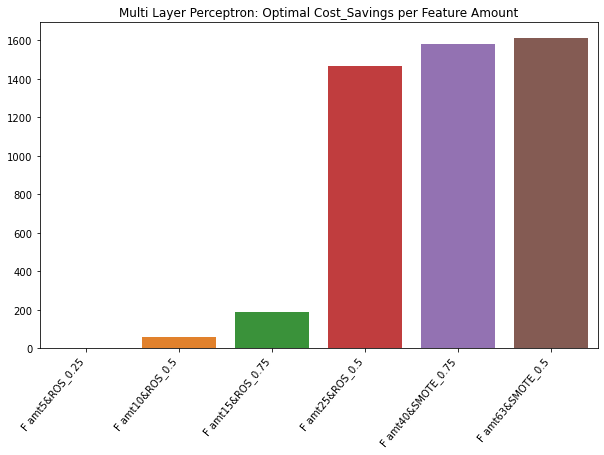

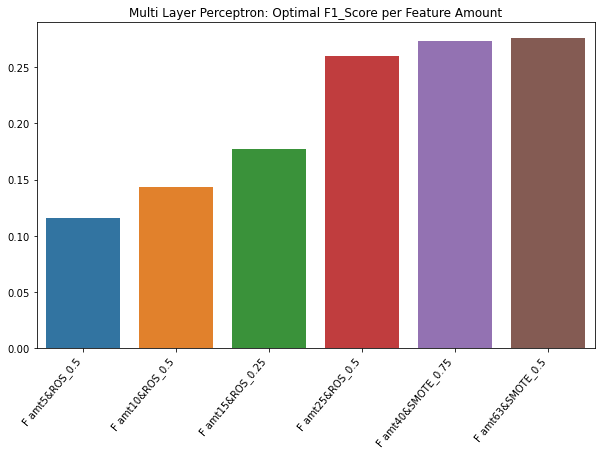

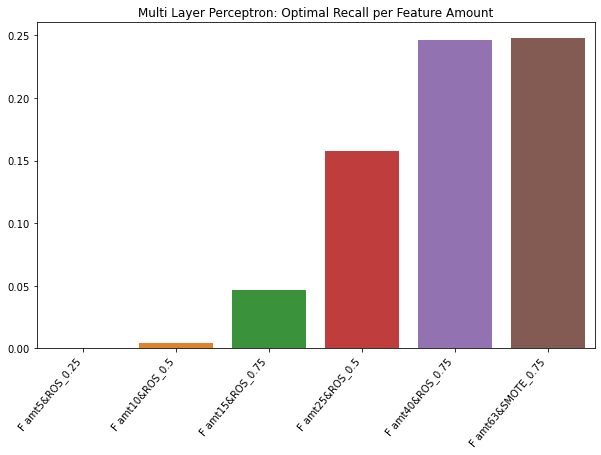

In [22]:
view_optimization(method_ratio_combo,Opt_data_frame,'Multi Layer Perceptron')

### Model building: SGDClassifier

In [20]:
# Find Optimal Feature Sampeling & ratio Amount
print('starting SGDClassifier Optimization')
start_time = time.time()
# Create DataFrane to store metrics and Feature_amt, Ratio, and Method Combinations in 
columns = ['Cost_Savings','F1_Score','Recall']
indexes = Feature_Amounts
Opt_data_frame = pd.DataFrame(columns=columns ,index=indexes)
method_ratio_combo =  pd.DataFrame(columns=columns ,index=indexes)
for f_amount in Feature_Amounts:
    print('testing Feature amount: ', f_amount)
    x_train_data = x_train[feat_importances[:f_amount].index]
    x_test_data = x_test[feat_importances[:f_amount].index]
    
    # optimize parameters 
    SGD = SGDClassifier(loss='log_loss')
    parameters = {
        'alpha':[.01,.001,.0001],
        'max_iter':[200,1000,2000]
    }
    opt_SGD = GridSearchCV(SGD, parameters)
    cost, f1, recall = test_create_sampled_data(class_probabilites, x_train_data, y_train, x_test_data, y_test, opt_SGD, cost_fn, cost_fp)
    
    print('Optimization for {} features completed'.format(f_amount))
    print(' ')
    print('cost optimization results: ',cost)
    print('f1 optimization results: ',f1)
    print('recall optimization results: ',recall)
    
    Opt_data_frame.loc[f_amount,'Cost_Savings'] = cost[0]
    method_ratio_combo.loc[f_amount,'Cost_Savings'] = str(cost[1])+'_'+str(cost[2])
    Opt_data_frame.loc[f_amount,'F1_Score'] = f1[0]
    method_ratio_combo.loc[f_amount,'F1_Score'] = str(f1[1])+'_'+str(f1[2])
    Opt_data_frame.loc[f_amount,'Recall'] = recall[0]
    method_ratio_combo.loc[f_amount,'Recall'] = str(recall[1])+'_'+str(recall[2])

# Get the best strategy combination and metric for each preformance metric
best_savings = Opt_data_frame['Cost_Savings'].max()
opt_feature_amt_savings = Opt_data_frame['Cost_Savings'].sort_values(ascending=False).index[0]
opt_sampel_savings = method_ratio_combo.loc[opt_feature_amt_savings,'Cost_Savings']

best_f1 = Opt_data_frame['F1_Score'].max()
opt_feature_amt_f1 = Opt_data_frame['F1_Score'].sort_values(ascending=False).index[0]
opt_sampel_f1 = method_ratio_combo.loc[opt_feature_amt_f1,'F1_Score']

best_recall = Opt_data_frame['Recall'].max()
opt_feature_amt_recall = Opt_data_frame['Recall'].sort_values(ascending=False).index[0]
opt_sampel_recall = method_ratio_combo.loc[opt_feature_amt_recall,'Recall']

print("Seconds Taken to SGDClassifier: ", (time.time() - start_time))

starting SGDClassifier Optimization
testing Feature amount:  5
  testing ratio amount:  0.25
    Finished Oversampling
    Finished Oversampling model training
    Finished Oversampling model cost optimization
    Finished Undersampling
    Finished Undersampling model training
    Finished Undersampling model cost optimization
    Finished Sythetic Oversampling Technique
    Finished Sythetic Oversampling Technique model training
    Finished Sythetic Oversampling model cost optimization
  testing ratio amount:  0.5
    Finished Oversampling
    Finished Oversampling model training
    Finished Oversampling model cost optimization
    Finished Undersampling
    Finished Undersampling model training
    Finished Undersampling model cost optimization
    Finished Sythetic Oversampling Technique
    Finished Sythetic Oversampling Technique model training
    Finished Sythetic Oversampling model cost optimization
  testing ratio amount:  0.75
    Finished Oversampling
    Finished Oversam

    Finished Oversampling model training
    Finished Oversampling model cost optimization
    Finished Undersampling
    Finished Undersampling model training
    Finished Undersampling model cost optimization
    Finished Sythetic Oversampling Technique
    Finished Sythetic Oversampling Technique model training
    Finished Sythetic Oversampling model cost optimization
  testing ratio amount:  0.75
    Finished Oversampling
    Finished Oversampling model training
    Finished Oversampling model cost optimization
    Finished Undersampling
    Finished Undersampling model training
    Finished Undersampling model cost optimization
    Finished Sythetic Oversampling Technique
    Finished Sythetic Oversampling Technique model training
    Finished Sythetic Oversampling model cost optimization
Optimization for 63 features completed
 
cost optimization results:  [1687.3461605698308, 'ROS', 0.25]
f1 optimization results:  [0.28937728937728935, 'SMOTE', 0.75]
recall optimization results:

<Figure size 1080x432 with 0 Axes>

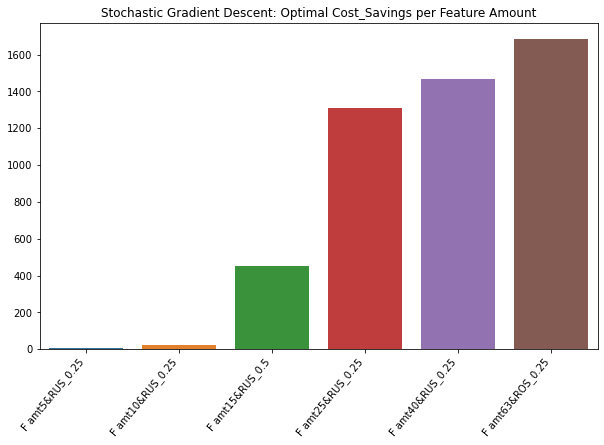

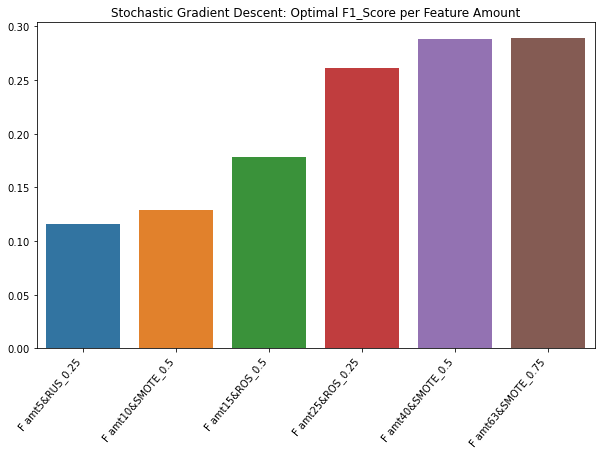

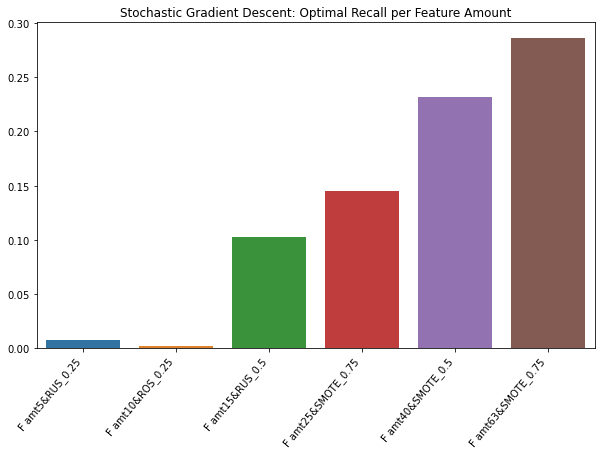

In [21]:
view_optimization(method_ratio_combo,Opt_data_frame,'Stochastic Gradient Descent')

### Model building: GradientBoostingClassifier

In [20]:
# Find Optimal Feature Sampeling & ratio Amount
print('starting GradientBoostingClassifier Optimization')
start_time = time.time()
# Create DataFrane to store metrics and Feature_amt, Ratio, and Method Combinations in 
columns = ['Cost_Savings','F1_Score','Recall']
indexes = Feature_Amounts
Opt_data_frame = pd.DataFrame(columns=columns ,index=indexes)
method_ratio_combo =  pd.DataFrame(columns=columns ,index=indexes)
for f_amount in Feature_Amounts:
    print('testing Feature amount: ', f_amount)
    x_train_data = x_train[feat_importances[:f_amount].index]
    x_test_data = x_test[feat_importances[:f_amount].index]
    
    # optimize parameters 
    GBC = GradientBoostingClassifier()
    parameters = {
        'n_estimators':[50,100,200],
        'max_depth':[2,3,5],
        'min_samples_split':[2,10]
    }
    opt_GBC = GridSearchCV(GBC, parameters)
    cost, f1, recall = test_create_sampled_data(class_probabilites, x_train_data, y_train, x_test_data, y_test, opt_GBC, cost_fn, cost_fp)
    
    print('Optimization for {} features completed'.format(f_amount))
    print(' ')
    print('cost optimization results: ',cost)
    print('f1 optimization results: ',f1)
    print('recall optimization results: ',recall)
    
    Opt_data_frame.loc[f_amount,'Cost_Savings'] = cost[0]
    method_ratio_combo.loc[f_amount,'Cost_Savings'] = str(cost[1])+'_'+str(cost[2])
    Opt_data_frame.loc[f_amount,'F1_Score'] = f1[0]
    method_ratio_combo.loc[f_amount,'F1_Score'] = str(f1[1])+'_'+str(f1[2])
    Opt_data_frame.loc[f_amount,'Recall'] = recall[0]
    method_ratio_combo.loc[f_amount,'Recall'] = str(recall[1])+'_'+str(recall[2])

# Get the best strategy combination and metric for each preformance metric
best_savings = Opt_data_frame['Cost_Savings'].max()
opt_feature_amt_savings = Opt_data_frame['Cost_Savings'].sort_values(ascending=False).index[0]
opt_sampel_savings = method_ratio_combo.loc[opt_feature_amt_savings,'Cost_Savings']

best_f1 = Opt_data_frame['F1_Score'].max()
opt_feature_amt_f1 = Opt_data_frame['F1_Score'].sort_values(ascending=False).index[0]
opt_sampel_f1 = method_ratio_combo.loc[opt_feature_amt_f1,'F1_Score']

best_recall = Opt_data_frame['Recall'].max()
opt_feature_amt_recall = Opt_data_frame['Recall'].sort_values(ascending=False).index[0]
opt_sampel_recall = method_ratio_combo.loc[opt_feature_amt_recall,'Recall']

print("Seconds Taken to GradientBoostingClassifier: ", (time.time() - start_time))

starting GradientBoostingClassifier Optimization
testing Feature amount:  5
  testing ratio amount:  0.25
    Finished Oversampling
    Finished Oversampling model training
    Finished Oversampling model cost optimization
    Finished Undersampling
    Finished Undersampling model training
    Finished Undersampling model cost optimization
    Finished Sythetic Oversampling Technique
    Finished Sythetic Oversampling Technique model training
    Finished Sythetic Oversampling model cost optimization
  testing ratio amount:  0.5
    Finished Oversampling
    Finished Oversampling model training
    Finished Oversampling model cost optimization
    Finished Undersampling
    Finished Undersampling model training
    Finished Undersampling model cost optimization
    Finished Sythetic Oversampling Technique
    Finished Sythetic Oversampling Technique model training
    Finished Sythetic Oversampling model cost optimization
  testing ratio amount:  0.75
    Finished Oversampling
    Fin

    Finished Oversampling model training
    Finished Oversampling model cost optimization
    Finished Undersampling
    Finished Undersampling model training
    Finished Undersampling model cost optimization
    Finished Sythetic Oversampling Technique
    Finished Sythetic Oversampling Technique model training
    Finished Sythetic Oversampling model cost optimization
  testing ratio amount:  0.75
    Finished Oversampling
    Finished Oversampling model training
    Finished Oversampling model cost optimization
    Finished Undersampling
    Finished Undersampling model training
    Finished Undersampling model cost optimization
    Finished Sythetic Oversampling Technique
    Finished Sythetic Oversampling Technique model training
    Finished Sythetic Oversampling model cost optimization
Optimization for 63 features completed
 
cost optimization results:  [1790.264688784764, 'RUS', 0.5]
f1 optimization results:  [0.2916666666666667, 'RUS', 0.5]
recall optimization results:  [0.2

<Figure size 1080x432 with 0 Axes>

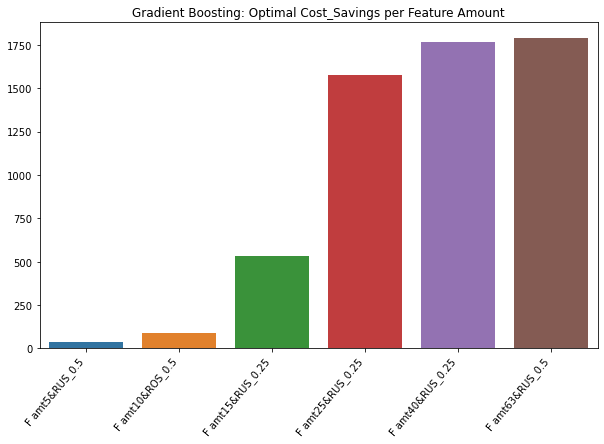

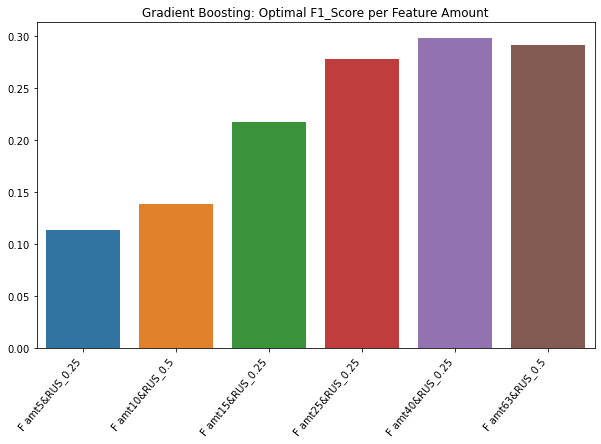

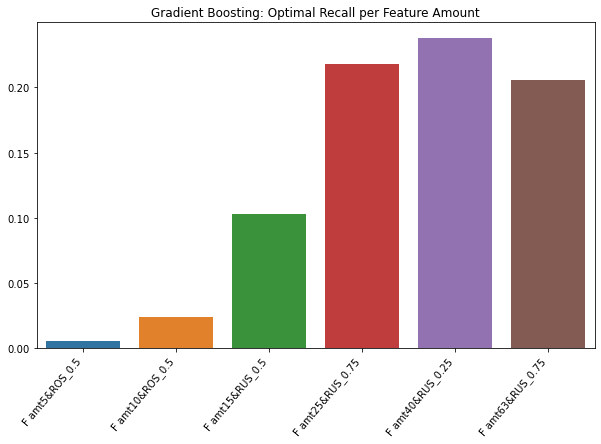

In [21]:
view_optimization(method_ratio_combo,Opt_data_frame,'Gradient Boosting')

### Model building: AdaBoostClassifier

In [20]:
# Find Optimal Feature Sampeling & ratio Amount
print('starting AdaBoostClassifier Optimization')
start_time = time.time()
# Create DataFrane to store metrics and Feature_amt, Ratio, and Method Combinations in 
columns = ['Cost_Savings','F1_Score','Recall']
indexes = Feature_Amounts
Opt_data_frame = pd.DataFrame(columns=columns ,index=indexes)
method_ratio_combo =  pd.DataFrame(columns=columns ,index=indexes)
for f_amount in Feature_Amounts:
    print('testing Feature amount: ', f_amount)
    x_train_data = x_train[feat_importances[:f_amount].index]
    x_test_data = x_test[feat_importances[:f_amount].index]
    
    # optimize parameters 
    ABC = AdaBoostClassifier()
    parameters = {
        'n_estimators':[25,50,100,200,400]
    }
    opt_ABC = GridSearchCV(ABC, parameters)
    cost, f1, recall = test_create_sampled_data(class_probabilites, x_train_data, y_train, x_test_data, y_test, opt_ABC, cost_fn, cost_fp)
    
    print('Optimization for {} features completed'.format(f_amount))
    print(' ')
    print('cost optimization results: ',cost)
    print('f1 optimization results: ',f1)
    print('recall optimization results: ',recall)
    
    Opt_data_frame.loc[f_amount,'Cost_Savings'] = cost[0]
    method_ratio_combo.loc[f_amount,'Cost_Savings'] = str(cost[1])+'_'+str(cost[2])
    Opt_data_frame.loc[f_amount,'F1_Score'] = f1[0]
    method_ratio_combo.loc[f_amount,'F1_Score'] = str(f1[1])+'_'+str(f1[2])
    Opt_data_frame.loc[f_amount,'Recall'] = recall[0]
    method_ratio_combo.loc[f_amount,'Recall'] = str(recall[1])+'_'+str(recall[2])

# Get the best strategy combination and metric for each preformance metric
best_savings = Opt_data_frame['Cost_Savings'].max()
opt_feature_amt_savings = Opt_data_frame['Cost_Savings'].sort_values(ascending=False).index[0]
opt_sampel_savings = method_ratio_combo.loc[opt_feature_amt_savings,'Cost_Savings']

best_f1 = Opt_data_frame['F1_Score'].max()
opt_feature_amt_f1 = Opt_data_frame['F1_Score'].sort_values(ascending=False).index[0]
opt_sampel_f1 = method_ratio_combo.loc[opt_feature_amt_f1,'F1_Score']

best_recall = Opt_data_frame['Recall'].max()
opt_feature_amt_recall = Opt_data_frame['Recall'].sort_values(ascending=False).index[0]
opt_sampel_recall = method_ratio_combo.loc[opt_feature_amt_recall,'Recall']

print("Seconds Taken to AdaBoostClassifier: ", (time.time() - start_time))

starting AdaBoostClassifier Optimization
testing Feature amount:  5
  testing ratio amount:  0.25
    Finished Oversampling
    Finished Oversampling model training
    Finished Oversampling model cost optimization
    Finished Undersampling
    Finished Undersampling model training
    Finished Undersampling model cost optimization
    Finished Sythetic Oversampling Technique
    Finished Sythetic Oversampling Technique model training
    Finished Sythetic Oversampling model cost optimization
  testing ratio amount:  0.5
    Finished Oversampling
    Finished Oversampling model training
    Finished Oversampling model cost optimization
    Finished Undersampling
    Finished Undersampling model training
    Finished Undersampling model cost optimization
    Finished Sythetic Oversampling Technique
    Finished Sythetic Oversampling Technique model training
    Finished Sythetic Oversampling model cost optimization
  testing ratio amount:  0.75
    Finished Oversampling
    Finished Ov

    Finished Oversampling model training
    Finished Oversampling model cost optimization
    Finished Undersampling
    Finished Undersampling model training
    Finished Undersampling model cost optimization
    Finished Sythetic Oversampling Technique
    Finished Sythetic Oversampling Technique model training
    Finished Sythetic Oversampling model cost optimization
  testing ratio amount:  0.75
    Finished Oversampling
    Finished Oversampling model training
    Finished Oversampling model cost optimization
    Finished Undersampling
    Finished Undersampling model training
    Finished Undersampling model cost optimization
    Finished Sythetic Oversampling Technique
    Finished Sythetic Oversampling Technique model training
    Finished Sythetic Oversampling model cost optimization
Optimization for 63 features completed
 
cost optimization results:  [1475.5620418969165, 'RUS', 0.25]
f1 optimization results:  [0.2598070739549839, 'RUS', 0.75]
recall optimization results:  [

<Figure size 1080x432 with 0 Axes>

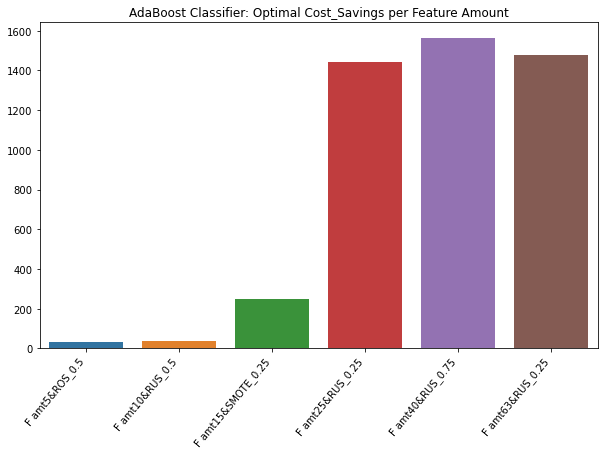

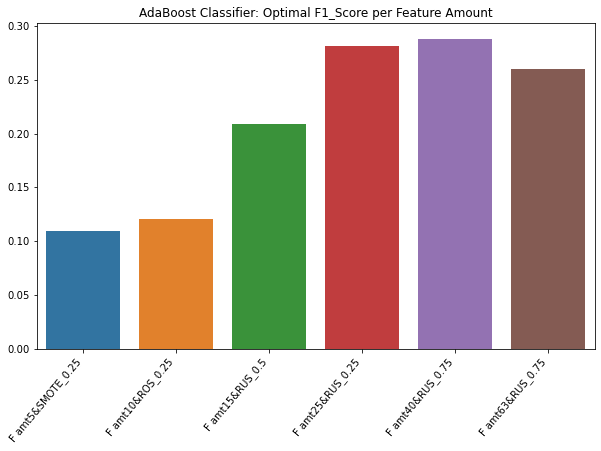

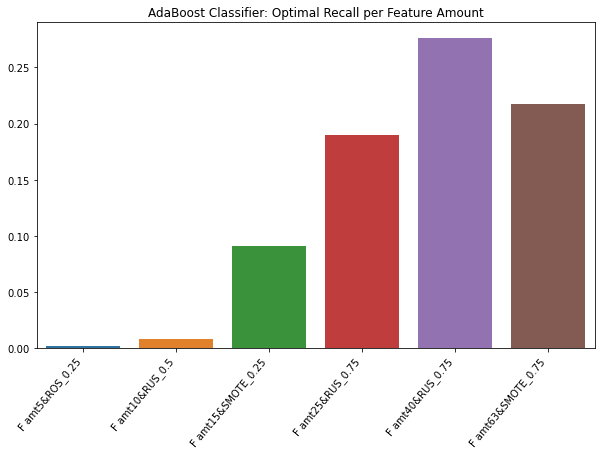

In [21]:
view_optimization(method_ratio_combo,Opt_data_frame,'AdaBoost Classifier')